# Stock market forecasting using Time Series analysis

### Load all the required libraries

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.4 MB/s eta 0:00:00


In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
import yfinance as yf
stock_data = yf.download(tickers="AAPL", start="2005-02-25",end="2017-11-10",progress=False)
# code for extracting data of apple stock from start = "2005-02-25" to end ="2017-11-10"
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-02-25,1.600357,1.605536,1.574821,1.589107,1.348828,915510400
2005-02-28,1.595714,1.612143,1.570000,1.602143,1.359893,651610400
2005-03-01,1.606786,1.611071,1.577143,1.589286,1.348981,468188000
2005-03-02,1.580357,1.603214,1.574286,1.575714,1.337461,458161200
2005-03-03,1.584643,1.586071,1.472143,1.492500,1.266829,1411653600
...,...,...,...,...,...,...
2017-11-03,43.500000,43.564999,42.779999,43.125000,40.687073,237594400
2017-11-06,43.092499,43.747501,42.930000,43.562500,41.099831,140105200
2017-11-07,43.477501,43.812500,43.400002,43.702499,41.231926,97446000


In [4]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-02-25,1.600357,1.605536,1.574821,1.589107,1.348828,915510400
2005-02-28,1.595714,1.612143,1.570000,1.602143,1.359893,651610400
2005-03-01,1.606786,1.611071,1.577143,1.589286,1.348981,468188000
2005-03-02,1.580357,1.603214,1.574286,1.575714,1.337461,458161200
2005-03-03,1.584643,1.586071,1.472143,1.492500,1.266829,1411653600
...,...,...,...,...,...,...
2017-11-03,43.500000,43.564999,42.779999,43.125000,40.687073,237594400
2017-11-06,43.092499,43.747501,42.930000,43.562500,41.099831,140105200
2017-11-07,43.477501,43.812500,43.400002,43.702499,41.231926,97446000


In [5]:
df_close  = stock_data.Close

Visualize the per day closing price of the stock.

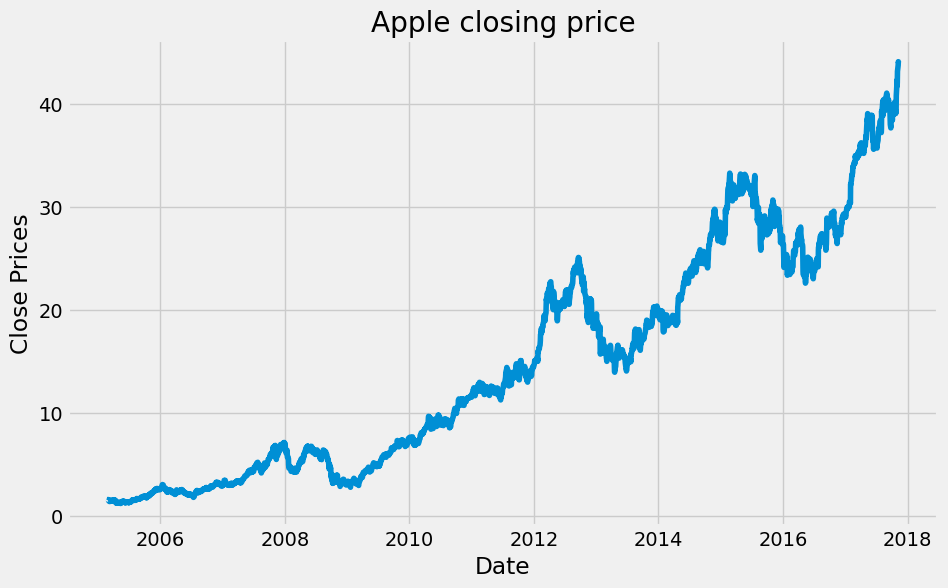

In [6]:
#plotting the close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('Apple closing price')
plt.show()

In [7]:
# using the dickey-fuller test to check the stationarity in the time series
def test_stationarity(df_close):
    adf = adfuller(df_close)

    print('ADF Statistic: {}'.format(adf[0]))
    print('p-value: {}'.format(adf[1]))

    if adf[1] < 0.05:
        print('The data is stationary')
    else:
        print('The data is not stationary')
    #Your code here


In [8]:
test_stationarity(df_close)

ADF Statistic: 1.0012740459210665
p-value: 0.9942793730386913
The data is not stationary


<Figure size 1000x600 with 0 Axes>

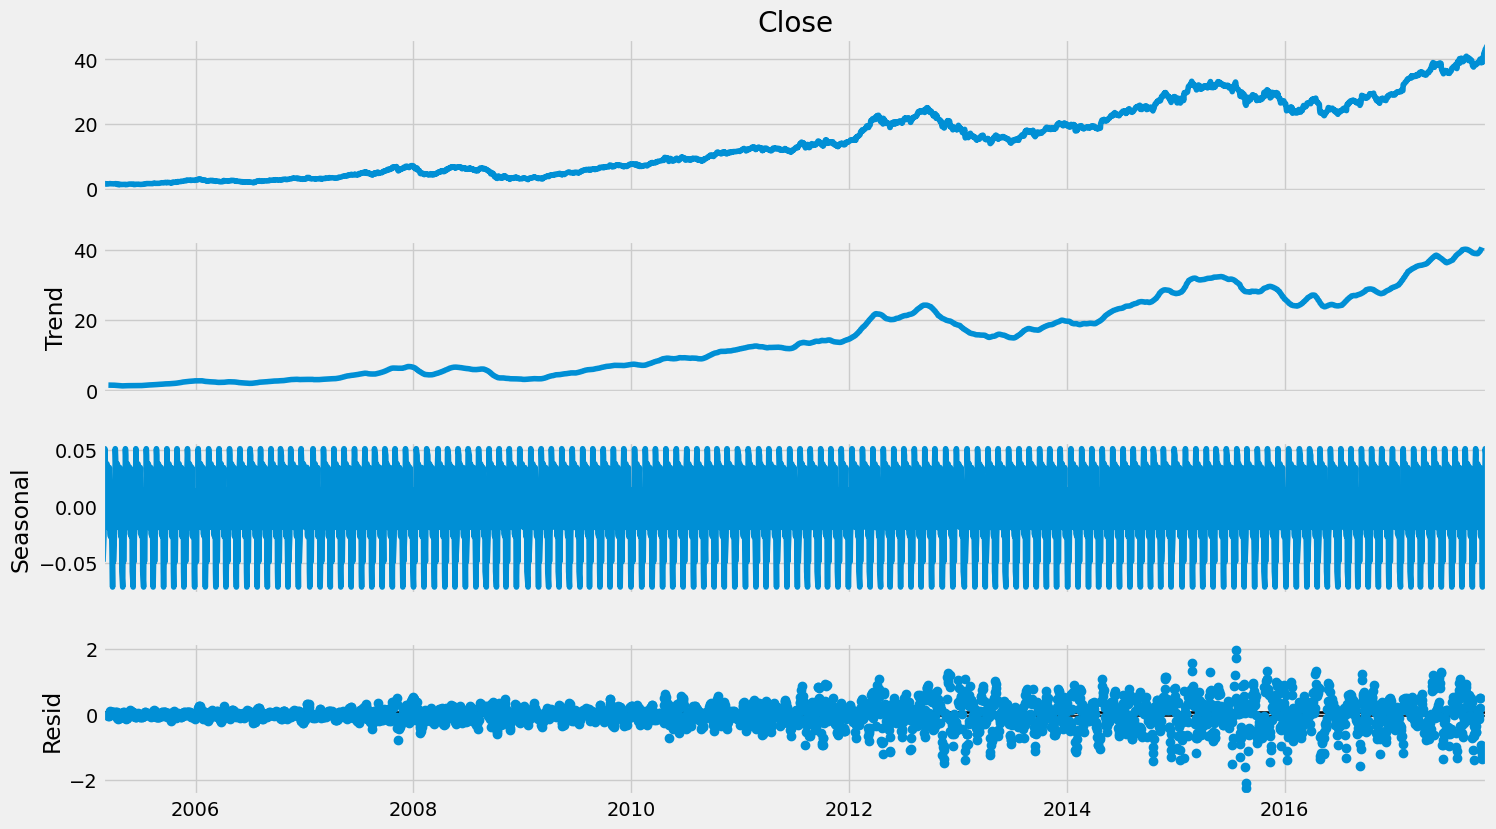

In [9]:
#To separate the trend and the seasonality from a time series,
# we can decompose the time series .

result = seasonal_decompose(df_close, period=24)
trend = result.trend
seasonal = result.seasonal


fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

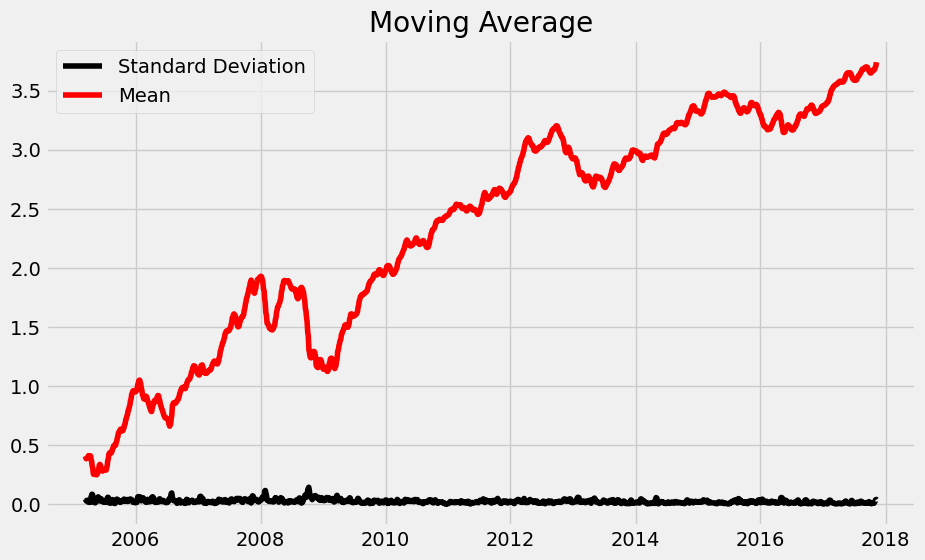

In [10]:
#Eliminating trend using moving Average and SD
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

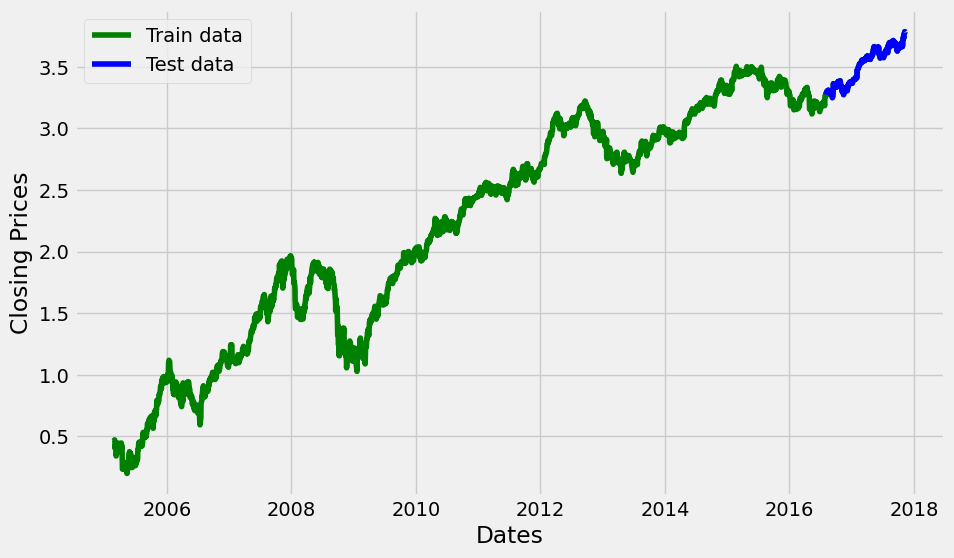

In [11]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):] #applying log transform for better correlation
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13889.421, Time=0.34 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13887.422, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13887.417, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13885.507, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13885.782, Time=1.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.583 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2877
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6946.711
Date:                Sat, 12 Aug 2023   AIC                         -13889.421
Time:                        12:35:40   BIC                         -13877.493
Sample:                             0   HQIC                        -13885.122
                               - 2877                             

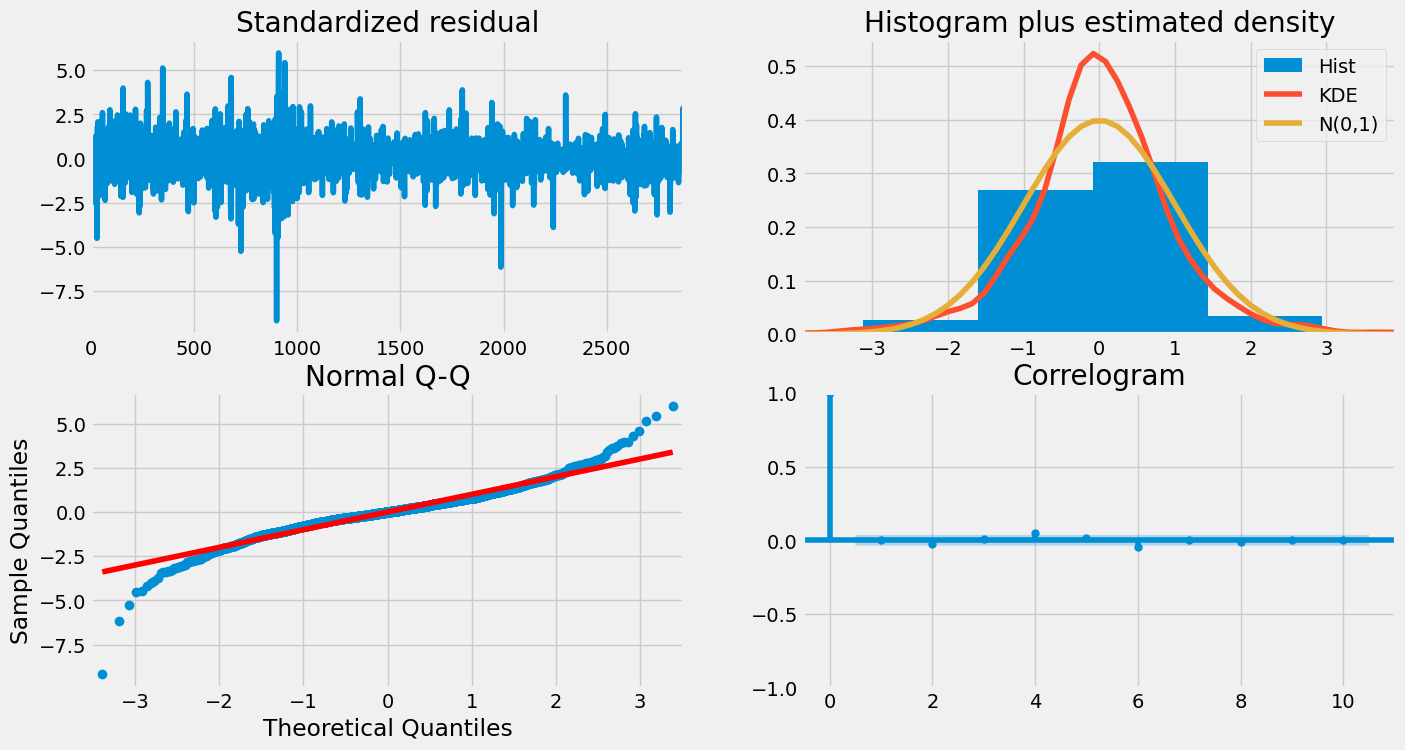

In [12]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Auto ARIMA model provided the value of p,d, and q use these values to train the arima model.**

In [13]:
#train the Arima Model with Order (p , d , q)

def train(p , d , q):

  model = ARIMA(train_data, order=(p, d, q))
  model = model.fit()
  return model


### Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

In [14]:
# Forecast
p = 0
q = 0
d = 1
model = train(p , d , q)
fc = model.forecast(321, alpha=0.05)  # 95% conf

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Plot the results

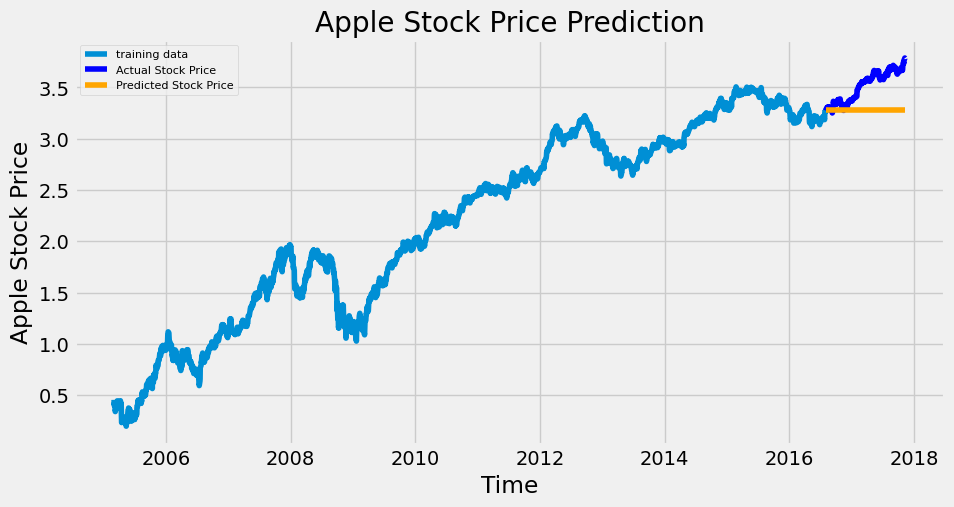

In [15]:
# Make as pandas series
fc_series = fc
fc_series.index = test_data.index
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Let us check the commonly used accuracy metrics to judge forecast results:

In [16]:
#Calculate the RMSE and Absolute error using Scikit Learn Function
mse = mean_squared_error(test_data, fc_series)
rmse = math.sqrt(mse)
absolute = mean_absolute_error(test_data, fc_series)

print(rmse)
print(absolute)

0.2805681333111673
0.2386589337234662
